# LangGraph Chatbot 구축

먼저 `LangGraph` 를 사용하여 사용자 메시지에 직접 응답하는 간단한 챗봇을 만들어 볼 것이다.

`StateGraph`를 생성한 뒤, `StateGraph` 객체의 챗봇 구조를 "상태 기계(State Machine)"로 정의한다.

`nodes`를 추가하여 챗봇이 호출할 수있는 LLM과 함수들을 나타내고, `edges`를 추가하여 봇이 이러한 함수들 간에 어떻게 전환해야하는지 지정한다.


In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from langchain_teddynote import logging
logging.langsmith("langgraph_chatbot_basic")

LangSmith 추적을 시작합니다.
[프로젝트명]
langgraph_chatbot_basic


## Step-by-Step 개념 이해하기

### Step 1. 상태(State) 정의

In [5]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph import add_messages

class State(TypedDict):
    # 메세지 정의(list tipe 이며 add_messages 함수를 사용하여 메시지를 추가)
    messages : Annotated[list, add_messages]

### Step 2. 노트(Node) 정의

다음으로 "Chatbot" 노드를 추가한다.
노드는 작업의 단위를 나타내며, 일반적으로 정규 Python 함수이다.

In [7]:
from langchain_openai import ChatOpenAI

# LLM정의
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.56)

# 챗봇 함수 정의 
def chatbot(state : State):
    return State(messages=llm.invoke(state["messages"]))
    # return{"messages": [llm.invoke(state["messages"])]}

### Step 3. 그래프 (Graph) 정의, 노드 추가

In [8]:
# 그래프 생성
graph_builder = StateGraph(State)

# 노드 이름, 함수 혹은 callable 객체를 인자로 받아 노드를 추가
graph_builder.add_node("chatbot", chatbot)

- `chatbot` 노드 함수는 현재 `State`를 입력으로 받아 "messages"라는 키 아래에 업데이트된 `messages` 목록을 포함하는 사전 (TypedDict)를 반환한다.

- `State`의 `add_messages 함수는 이미 상태에 있는 메시지에 LLM의 응답 메세지를 추가한다.

### Step 4. 그래프 엣지(Edge) 추가

그래프가 실행될때마다 **작업을 시작할 위치**인`START` 지점을 추가한다.

In [9]:
# 시작 노드에서 챗봇 노드로의 엣지 추가
graph_builder.add_edge(START, "chatbot")

마찬가지로, 그래프 흐름의 종료(끝지점)을 나타내는 `END`를 설정한다.

In [10]:
# 끝낼 노드 추가
graph_builder.add_edge("chatbot", END)

### Step 5. 그래프 컴파일(compile)

마지막으로, 그래프를 실행하기 위해 graph_builder에서 `compile()`을 호출해야한다. 

그리하면 상태에서 호출할수 있는 `CompiledGraph`가 탄생한다.

In [11]:
graph = graph_builder.compile()

### Step 6. 그래프 시작화 (visualization)

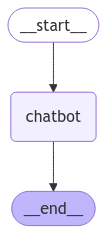

In [ ]:
from IPython.display import Image, display

img = Image(graph.get_graph(xray=True).draw_mermaid_png())

with open("graph.png", "wb") as f:
    f.write(img.data)

display(Image("graph.png"))



##################
# from langchain_teddynote.graphs import visualize_graph

# # 그래프 시각화
# visualize_graph(graph)

### Step 7. 그래프 실행

챗봇 실행하기

In [22]:
question = "서울의 유명한 맛집 Top 10 추천해줘"
# 그래프 이벤트 스트리밍
for event in graph.stream({"messages": [{"role": "user", "content": question}]}):
    # 이벤트값 출력
    print(event.values())
    for value in event.values():
        print("Assistant:", value["messages"].content)

dict_values([{'messages': AIMessage(content='서울에는 다양한 맛집이 많아서 선택하기가 쉽지 않지만, 다음은 서울에서 유명한 맛집 Top 10을 추천해 드립니다.\n\n1. **광장시장** - 다양한 전통 음식과 길거리 음식을 즐길 수 있는 시장. 특히 빈대떡과 마약김밥이 유명합니다.\n\n2. **이태원 앤드류스** - 다양한 세계 각국의 음식을 제공하는 레스토랑으로, 특히 양식과 브런치 메뉴가 인기입니다.\n\n3. **부암동 한옥집** - 전통 한옥에서 한식을 즐길 수 있는 곳으로, 고즈넉한 분위기에서 맛있는 식사를 할 수 있습니다.\n\n4. **삼청동 수제비** - 수제비와 칼국수로 유명한 이 곳은 진한 국물과 쫄깃한 면발이 일품입니다.\n\n5. **명동교자** - 칼국수와 만두가 유명한 맛집으로, 명동에서 꼭 들러야 할 곳 중 하나입니다.\n\n6. **종로 할머니순대** - 순대국밥과 다양한 순대 요리를 맛볼 수 있는 곳으로, 현지인들에게도 인기가 많습니다.\n\n7. **홍대 돈부리** - 일본식 덮밥 전문점으로, 다양한 토핑과 함께 즐길 수 있는 맛있는 덮밥을 제공합니다.\n\n8. **강남역 쭈꾸미** - 매콤한 쭈꾸미 요리로 유명한 맛집으로, 친구들과 함께 가기 좋은 곳입니다.\n\n9. **압구정 로데오 아구찜** - 아구찜과 아구수육이 유명한 곳으로, 매콤한 맛이 일품입니다.\n\n10. **신사동 가로수길 브런치 카페** - 다양한 브런치 메뉴와 디저트를 제공하는 카페들이 많아, 인스타그램 핫플레이스입니다.\n\n이 외에도 서울에는 많은 맛집이 있으니, 방문하실 때 꼭 다양한 음식을 경험해 보세요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 457, 'prompt_tokens': 19, 'total_tokens': 476, 'completion_tokens_details': 

### 전체 코드

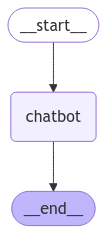

dict_values([{'messages': [AIMessage(content='샤로수길은 서울에서 맛있는 음식과 분위기를 즐길 수 있는 곳으로 유명합니다. 여기 샤로수길에 있는 추천 식당 10곳을 소개해드릴게요.\n\n1. **연남서식당** - 전통 한국식 반찬과 함께하는 한식당으로, 소박하면서도 정갈한 맛을 자랑합니다.\n\n2. **바오바오** - 인기 있는 중식당으로, 다양한 종류의 만두와 볶음밥을 제공합니다.\n\n3. **스시노점** - 신선한 재료로 만든 초밥과 사시미를 즐길 수 있는 일식당입니다.\n\n4. **모퉁이** - 아늑한 분위기에서 다양한 이탈리안 요리를 맛볼 수 있는 곳으로, 특히 파스타가 인기입니다.\n\n5. **동경** - 정통 일본식 라멘과 덮밥을 제공하는 식당으로, 맛과 분위기가 좋습니다.\n\n6. **한남동 그릴** - 고급스러운 분위기에서 스테이크와 그릴 요리를 즐길 수 있는 레스토랑입니다.\n\n7. **피어 8** - 해산물 요리를 전문으로 하는 식당으로, 신선한 재료로 만든 다양한 메뉴가 있습니다.\n\n8. **수제버거** - 수제버거와 감자튀김을 전문으로 하는 캐주얼한 분위기의 식당입니다.\n\n9. **고기리 막창** - 맛있는 막창과 고기를 즐길 수 있는 고기 전문점으로, 저녁 시간에 특히 인기가 많습니다.\n\n10. **카페 드 파리** - 디저트와 커피를 전문으로 하는 카페로, 분위기가 좋고 달콤한 메뉴가 많습니다.\n\n각 식당마다 특색이 있으니, 원하는 메뉴와 분위기에 맞춰 방문해보세요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 411, 'prompt_tokens': 27, 'total_tokens': 438, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoni

In [25]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import  add_messages
from langchain_openai import ChatOpenAI
from IPython.display import Image, display

### STEP 1. STATE 정의 ###
class State(TypedDict):
    # 메세지 정의 (list type 이며 add_message함수를 사용하여 메세지가 추가 됨.)
    messages : Annotated[list, add_messages]

### STEP 2. NODE 정의 ###
# LLM 정의
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.76)

# chatbot 함수 정의
def chatbot(state: State):
    # 메세지 호출 및 반환
    # return {"messages": [llm.invoke(state["messages"])]}
    return State(messages=[llm.invoke(state["messages"])])


### STEP 3. GRAPH 정의 및 노드 추가 ###
# 그래프 생성
graph_builder = StateGraph(State)

# 노드 이름, 함수 혹은 callable 객체를 인자로 받아 노드를 추가
graph_builder.add_node("chatbot", chatbot)

### STEP 4. Graph 엣지 추가 : 시작과 끝 설정 ###
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

### STEP 5. 그래프 컴파일
graph = graph_builder.compile()

### STEP 6. 시각화 ###
img = Image(graph.get_graph(xray=True).draw_mermaid_png())

with open("graph.png", "wb") as f:
    f.write(img.data)

display(Image("graph.png"))


# question = "서울의 유명한 맛집 Top 10 추천해줘"
# # 그래프 이벤트 스트리밍
# for event in graph.stream({"messages": [{"role": "user", "content": question}]}):
#     # 이벤트값 출력
#     print(event.values())
#     for value in event.values():
#         print("Assistant:", value["messages"].content)

### STEP 7. 그래프 실행 ###
question = "샤로수길에 있는 유명한 식당 10군데 추천해줘."

for event in graph.stream({"messages": [{"role": "user", "content": question}]}):
    print(event.values())
    # 이벤트 값 출력
    for value in event.values():
        print(value["messages"][-1].content)

